### Extract data from coinGeko API

In [77]:
import logging

from pyspark.sql import Window
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.types as T
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

from extractor.api.coingecko import CoinGeckoAPI


spark_session = (
    SparkSession.builder.appName("CoinGeckoAPI")
    .config(
        "spark.jars",
        "/home/jovyan/connectors/postgresql-42.7.5.jar,/home/jovyan/connectors/iceberg-spark-runtime-3.5_2.12-1.9.0.jar",
    )
    .getOrCreate()
)

spark_session.conf.set(
    "spark.sql.catalog.local", "org.apache.iceberg.spark.SparkCatalog"
)
spark_session.conf.set("spark.sql.catalog.local.type", "hadoop")
spark_session.conf.set("spark.sql.catalog.local.warehouse", "/home/jovyan/warehouse")

### Extract process

In [78]:
def extract_process(
    api_key: str,
    coningecko_base_url: str,
    coin_id: str,
    currency_code: str,
    start_timestamp: int,
    end_timestamp: int,
):

    coin_gecko_extractor = CoinGeckoAPI(spark_session, api_key, coningecko_base_url)

    extractor_value = coin_gecko_extractor.extract_data_from_source(
        coin_id,
        currency_code,
        start_timestamp,
        end_timestamp,
    )

    if not extractor_value:
        logger.error(f"No se pudo extraer datos para {coin_id}")
        return None

    return extractor_value

### Transform Process

In [79]:
def transform_process(extractor_value: dict, spark_session: SparkSession) -> DataFrame:
    """
    Transforms CoinGecko market data into a PySpark DataFrame including:
    - raw timestamp in milliseconds
    - event timestamp and date
    - daily average price
    - 5-day moving average of the daily price
    - coin metadata (id, symbol, name)

    The 5-day moving average is calculated using a window that includes:
    - The current date (0)
    - The previous 4 days (-4)

    Therefore: rowsBetween(-4, 0) covers a 5-day rolling window.

    Args:
        extractor_value (dict): Dictionary containing:
            - 'coin_info': metadata about the coin
            - 'market_data': list of [timestamp, price] pairs
        spark_session (SparkSession): Active Spark session

    Returns:
        DataFrame: Final DataFrame with the following columns:
            - timestamp_ms
            - event_timestamp
            - event_date
            - price
            - coin_id, symbol, coin_name
            - daily_avg_price
            - price_moving_avg_5d
    """
    coin_info = extractor_value.get("coin_info", {})
    market_data = extractor_value.get("market_data", [])

    if not market_data:
        raise ValueError("No market_data found to transform.")

    # Create base DataFrame
    df = spark_session.createDataFrame(
        market_data,
        schema=T.StructType(
            [
                T.StructField("timestamp_ms", T.LongType(), True),
                T.StructField("price", T.DoubleType(), True),
            ]
        ),
    )

    MILLISECONDS_IN_SECOND = 1000
    df = df.withColumn(
        "event_timestamp",
        (F.col("timestamp_ms") / MILLISECONDS_IN_SECOND).cast("timestamp"),
    )

    df = df.withColumn("event_date", F.to_date("event_timestamp"))
    df = df.dropDuplicates(["event_timestamp", "price"])

    # Add metadata
    df = df.withColumn("coin_id", F.lit(coin_info.get("id", "unknown")))
    df = df.withColumn("symbol", F.lit(coin_info.get("symbol", "")))
    df = df.withColumn("coin_name", F.lit(coin_info.get("name", "")))

    # Compute daily average price
    daily_avg = df.groupBy("event_date").agg(F.avg("price").alias("daily_avg_price"))

    # Compute 5-day moving average using a rolling window
    WINDOW_DAYS = 5
    WINDOW_START = -(WINDOW_DAYS - 1)  # includes previous 4 days
    WINDOW_END = 0  # includes current day

    window_spec = Window.orderBy("event_date").rowsBetween(WINDOW_START, WINDOW_END)
    daily_avg = daily_avg.withColumn(
        "price_moving_avg_5d", F.avg("daily_avg_price").over(window_spec)
    )

    # Join back daily averages to original data
    df = df.join(daily_avg, on="event_date", how="left")

    return df

### Load Process

In [80]:
def load_to_postgres(df: DataFrame, table_name: str) -> bool:
    if df is None or df.rdd.isEmpty():
        logger.warning("⚠️  DataFrame is empty. Skipping PostgreSQL load.")
        return False

    try:
        logger.info(f"🚀 Writing DataFrame to PostgreSQL table '{table_name}'...")

        df.write.jdbc(
            url="jdbc:postgresql://postgres:5432/database",
            table=table_name,
            mode="overwrite",
            properties={
                "user": "postgres",
                "password": "postgres",
                "driver": "org.postgresql.Driver",
            },
        )

        logger.info(f"✅ PostgreSQL load complete: {table_name}")
        return True

    except Exception as e:
        logger.exception(f"❌ Error writing to PostgreSQL: {e}")
        return False

In [81]:
def load_to_iceberg(df: DataFrame, table_name: str, catalog: str = "local") -> bool:

    if df is None or df.rdd.isEmpty():
        logger.warning("DataFrame is empty. Skipping Iceberg load.")
        return False

    try:
        spark_session.sql(
            """
                CREATE TABLE IF NOT EXISTS local.default.price_market_data (
                    event_date DATE,
                    daily_avg_price DOUBLE,
                    coin_id STRING,
                    symbol STRING,
                    coin_name STRING,
                    price_moving_avg_5d DOUBLE
                )
                USING iceberg
                PARTITIONED BY (coin_id)
            """
        )

        df.writeTo(f"{catalog}.default.{table_name}").using("iceberg").tableProperty(
            "format-version", "2"
        ).partitionedBy("coin_id").createOrReplace()

        logger.info(f"✅ Iceberg load complete")
        return True

    except Exception as e:
        logger.exception(f"Error writing to Iceberg: {e}")
        return False

In [82]:
def load_process(df: DataFrame, table_name: str) -> bool:
    """
    Load the transformed DataFrame to both PostgreSQL and Iceberg.

    Args:
        df (DataFrame): Transformed DataFrame to load.
        table_name (str): Name of the table to load data into.

    Returns:
        bool: True if both loads were successful, False otherwise.
    """
    postgres_success = load_to_postgres(df, table_name)
    iceberg_success = load_to_iceberg(df, table_name)

    return postgres_success and iceberg_success

### Visualizations

In [83]:

def visualization(df_spark: DataFrame) -> None:

    df_pd = df_spark.select("timestamp_ms", "price").toPandas()
    df_pd["timestamp"] = pd.to_datetime(df_pd["timestamp_ms"], unit="ms")
    df_pd = df_pd.sort_values("timestamp")

    # get max and min price
    max_row = df_pd.loc[df_pd["price"].idxmax()]
    min_row = df_pd.loc[df_pd["price"].idxmin()]

    # create figure
    plt.figure(figsize=(14, 6))
    plt.plot(df_pd["timestamp"], df_pd["price"], label="Bitcoin Price", color="blue")

    # max value
    plt.annotate(
        f"Max\n{max_row['price']:.2f} USD",
        xy=(max_row["timestamp"], max_row["price"]),
        xytext=(0, 15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="green"),
        ha="center",
        fontsize=10,
        color="green",
    )

    # min value
    plt.annotate(
        f"Min\n{min_row['price']:.2f} USD",
        xy=(min_row["timestamp"], min_row["price"]),
        xytext=(0, -25),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="red"),
        ha="center",
        fontsize=10,
        color="red",
    )

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d\n%H:%M"))
    plt.xticks(rotation=45)
    plt.title("Bitcoin Price with Max/Min Annotations")
    plt.xlabel("Timestamp")
    plt.ylabel("Price (USD)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Data Analysis

In [84]:
def analitycs_trends(df_spark):

    df_pd = (
        df_spark.select("event_date", "daily_avg_price", "price_moving_avg_5d")
        .distinct()
        .toPandas()
    )

    df_pd["event_date"] = pd.to_datetime(df_pd["event_date"])
    df_pd = df_pd.sort_values("event_date")

    plt.figure(figsize=(14, 7))
    plt.plot(
        df_pd["event_date"],
        df_pd["daily_avg_price"],
        label="Daily moving average (1 day)",
        color="blue",
        linewidth=2,
    )
    plt.plot(
        df_pd["event_date"],
        df_pd["price_moving_avg_5d"],
        label="5-day moving average",
        color="orange",
        linewidth=2,
    )

    plt.fill_between(
        df_pd["event_date"],
        df_pd["daily_avg_price"],
        df_pd["price_moving_avg_5d"],
        where=(df_pd["daily_avg_price"] > df_pd["price_moving_avg_5d"]),
        interpolate=True,
        color="green",
        alpha=0.3,
        label="Upward Trend",
    )

    plt.fill_between(
        df_pd["event_date"],
        df_pd["daily_avg_price"],
        df_pd["price_moving_avg_5d"],
        where=(df_pd["daily_avg_price"] < df_pd["price_moving_avg_5d"]),
        interpolate=True,
        color="red",
        alpha=0.3,
        label="Downward Trend",
    )

    plt.title("Bitcoin Trends using Daily SMA and 5-Day SMA", fontsize=16)
    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Average Price (USD)", fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()

    plt.show()

### 🚪 Main Process

INFO:root:===================== Extracted Data =====================START
INFO:root:Extracted data: {'coin_info': {'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bitcoin'}, 'market_data': [[1735689663787, 93507.85874741491], [1735693440822, 94272.09391214595], [1735696972262, 93420.39375237148], [1735700622364, 93869.80795911608], [1735704236811, 93593.62756698632], [1735708079192, 93375.94075819162], [1735711366406, 93586.3591571702], [1735715016805, 93545.55552532309], [1735718628424, 93473.87147135605], [1735722225583, 93339.7181852846], [1735725684792, 93256.06930579936], [1735729682261, 93051.98323230208], [1735732870869, 93297.6075779421], [1735736573459, 93547.86133526727], [1735740477569, 94216.98076389902], [1735743831366, 93968.34922965291], [1735747443376, 94257.22814652258], [1735751027226, 93899.58728253447], [1735754505870, 93934.54706964073], [1735758233235, 94121.510119208], [1735761833428, 94468.70579080972], [1735765331836, 94572.55254464778], [1735769032647, 94783.154385

+----------+-------------+------------------+-----------------------+-------+------+---------+------------------+-------------------+
|event_date|timestamp_ms |price             |event_timestamp        |coin_id|symbol|coin_name|daily_avg_price   |price_moving_avg_5d|
+----------+-------------+------------------+-----------------------+-------+------+---------+------------------+-------------------+
|2025-01-09|1736427666950|93364.89605317505 |2025-01-09 13:01:06.95 |bitcoin|btc   |Bitcoin  |93510.68700847619 |97441.13202139693  |
|2025-01-09|1736424220439|93397.66850377186 |2025-01-09 12:03:40.439|bitcoin|btc   |Bitcoin  |93510.68700847619 |97441.13202139693  |
|2025-01-09|1736402617549|94413.64147771963 |2025-01-09 06:03:37.549|bitcoin|btc   |Bitcoin  |93510.68700847619 |97441.13202139693  |
|2025-01-09|1736453027451|92041.9420888766  |2025-01-09 20:03:47.451|bitcoin|btc   |Bitcoin  |93510.68700847619 |97441.13202139693  |
|2025-01-10|1736542857667|94749.6380033532  |2025-01-10 21:00:

INFO:root:🚀 Writing DataFrame to PostgreSQL table 'price_market_data'...
INFO:root:✅ PostgreSQL load complete: price_market_data
INFO:root:✅ Iceberg load complete
INFO:root:===================== Load Data =====================END
INFO:root:=============== Read data from PostgreSQL =================START
INFO:root:Reading data from PostgreSQL...🐘
INFO:root:=============== Read data from PostgreSQL =================START
INFO:root:============================ Visualization ========================START


+----------+-------------+-----------------+-----------------------+-------+------+---------+-----------------+-------------------+
|event_date|timestamp_ms |price            |event_timestamp        |coin_id|symbol|coin_name|daily_avg_price  |price_moving_avg_5d|
+----------+-------------+-----------------+-----------------------+-------+------+---------+-----------------+-------------------+
|2025-02-16|1739674838025|97548.37442069995|2025-02-16 03:00:38.025|bitcoin|btc   |Bitcoin  |97240.34965349374|96927.92988564108  |
|2025-02-16|1739725455153|97074.7553724119 |2025-02-16 17:04:15.153|bitcoin|btc   |Bitcoin  |97240.34965349374|96927.92988564108  |
|2025-02-16|1739729056263|96972.41824936462|2025-02-16 18:04:16.263|bitcoin|btc   |Bitcoin  |97240.34965349374|96927.92988564108  |
|2025-02-16|1739739834909|96915.58776734979|2025-02-16 21:03:54.909|bitcoin|btc   |Bitcoin  |97240.34965349374|96927.92988564108  |
|2025-02-16|1739678636282|97557.1527649986 |2025-02-16 04:03:56.282|bitcoin|

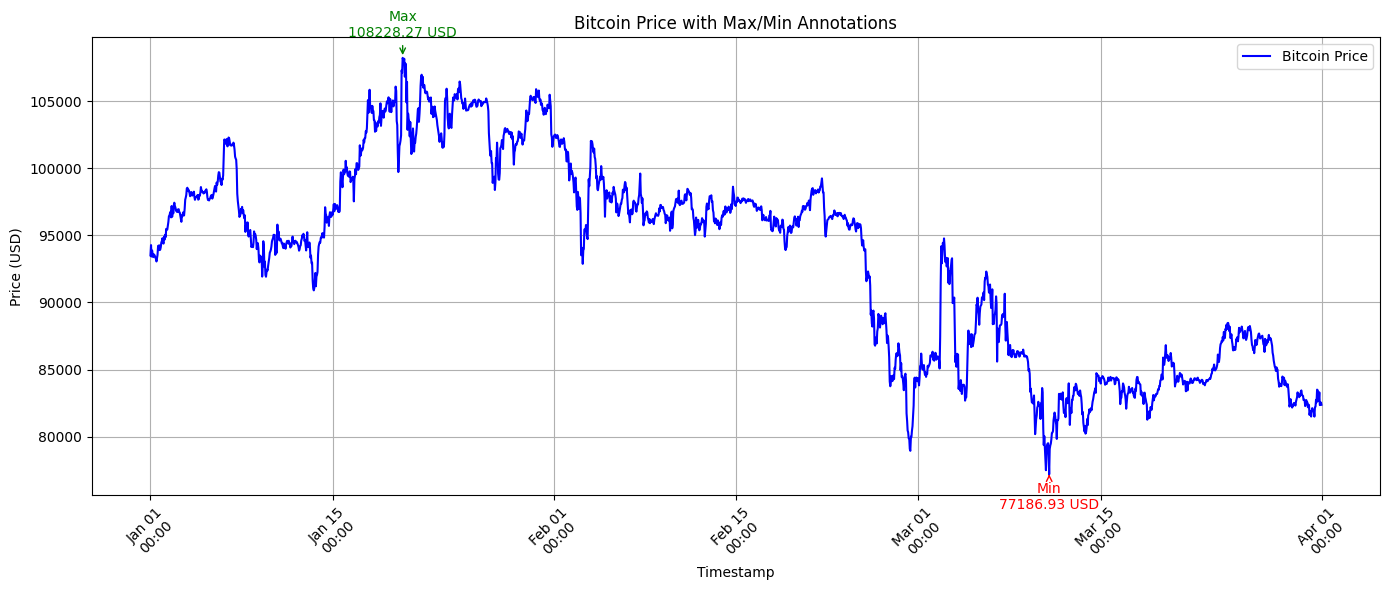

INFO:root:============================ Visualization ========================END
INFO:root:========================= Data Analytics =======================START


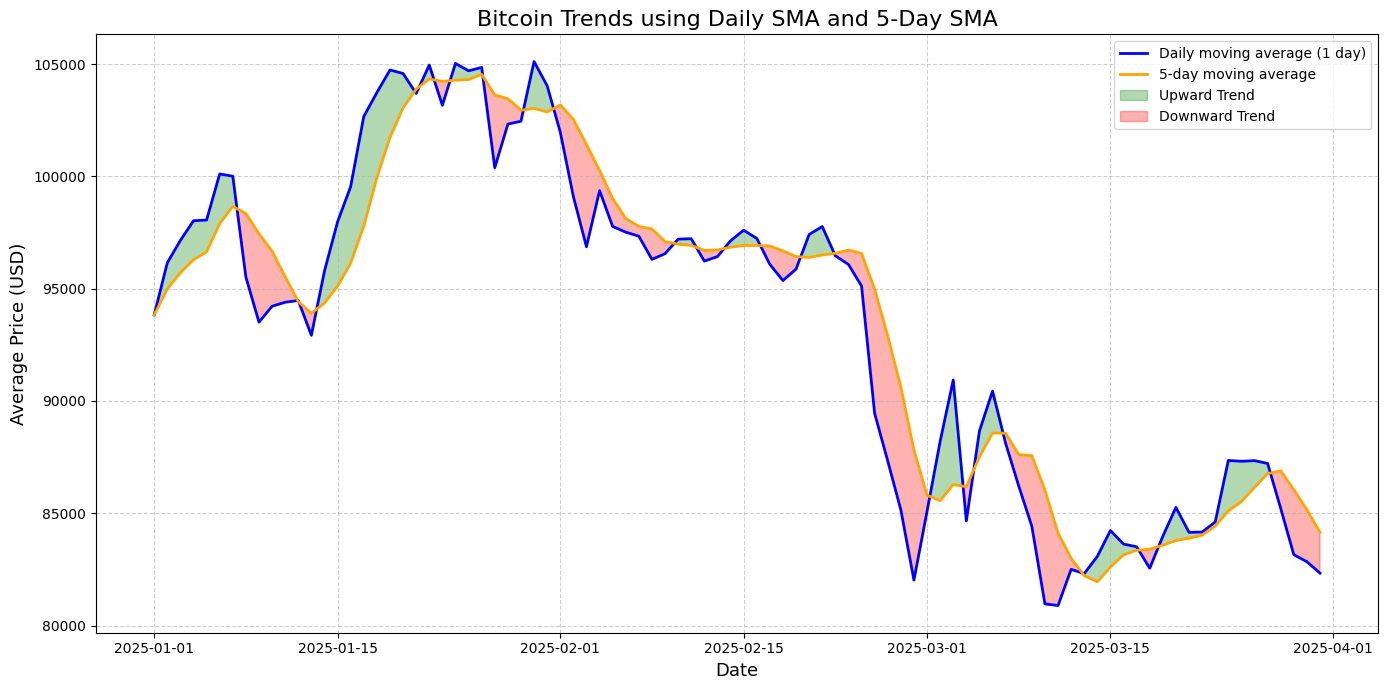

INFO:root:========================= Data Analytics =======================END


In [85]:
# ========================= MAIN FUNCTION =========================#


API_KEY = "CG-CKwwJYy4wv7nfumWdeFzZ6h9"
COINGECKO_BASE_URL = "https://api.coingecko.com/api/v3"
coin_id = "bitcoin"
vs_currency = "usd"
from_date = 1735689600  # 1 de enero de 2025
to_date = 1743465599  # 31 de marzo de 2025

logger.info("===================== Extracted Data =====================START")


extractor_value = extract_process(
    api_key=API_KEY,
    coningecko_base_url=COINGECKO_BASE_URL,
    coin_id=coin_id,
    currency_code=vs_currency,
    start_timestamp=from_date,
    end_timestamp=to_date,
)

logger.info(f"Extracted data: {extractor_value}")


logger.info("===================== Extracted Data =====================END")

logger.info("===================== Transformed Data =====================START")

df_spark = transform_process(
    extractor_value=extractor_value,
    spark_session=spark_session,
)

df_spark.show(truncate=False)

logger.info("===================== Transformed Data =====================END")



logger.info("===================== Load Data =====================START")

load_process(df_spark, table_name="price_market_data")


logger.info("===================== Load Data =====================END")


logger.info("=============== Read data from PostgreSQL =================START")


logger.info("Reading data from PostgreSQL...🐘")

df_postgres = spark_session.read.jdbc(
    url="jdbc:postgresql://postgres:5432/database",
    table="price_market_data",
    properties={
        "user": "postgres",
        "password": "postgres",
        "driver": "org.postgresql.Driver",
    },
)


df_postgres.show(20, truncate=False)

logger.info("=============== Read data from PostgreSQL =================START")


logger.info("============================ Visualization ========================START")

visualization(df_postgres)

logger.info("============================ Visualization ========================END")


logger.info("========================= Data Analytics =======================START")

analitycs_trends(df_postgres)

logger.info("========================= Data Analytics =======================END")